In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../..")

import numpy as np
import matplotlib.pyplot as plt
import os
from src import data
import json
from tqdm.auto import tqdm
from src.metrics import AggregateMetric
import logging

from src.utils import logging_utils
from src.utils.sweep_utils import read_sweep_results, relation_from_dict

# logging_utils.configure(level=logging.DEBUG)

In [3]:
##############################################
model_name = "gptj"
path = f"../../results/lre_stats/{model_name}"
##############################################

os.listdir(path)

['person_occupation',
 'landmark_in_country',
 'adjective_antonym',
 'person_mother',
 'country_capital_city',
 'plays_pro_sport',
 'person_plays_instrument',
 'person_university',
 'city_in_country',
 'food_from_country',
 'company_hq',
 'occupation_gender',
 'occupation_age',
 'name_gender',
 'word_first_letter',
 'country_language',
 'object_superclass',
 'name_religion',
 'person_native_language',
 'president_election_year',
 'fruit_outside_color',
 'superhero_archnemesis',
 'work_location',
 'landmark_on_continent',
 'person_lead_singer_of_band',
 'task_person_type',
 'characteristic_gender',
 'country_largest_city',
 'country_currency',
 'fruit_inside_color',
 'task_done_by_tool',
 'verb_past_tense',
 'star_constellation_name',
 'pokemon_evolution',
 'president_birth_year',
 'product_by_company',
 'name_birthplace',
 'word_last_letter',
 'word_sentiment',
 'company_CEO',
 'superhero_person',
 'person_father',
 'substance_phase_of_matter',
 'person_sport_position',
 'adjective_sup

In [4]:
relation = "country capital city"
relation_path = os.path.join(path, relation.replace(" ", "_"))
relation_path = os.path.join(relation_path, os.listdir(relation_path)[0])
sweep_results = read_sweep_results(
    sweep_dir=f"{relation_path}/{str(8)}",
)
relation = list(sweep_results.keys())[0]
relation_results = relation_from_dict(sweep_results[relation])

sweep_results[relation]["trials"][0]["layers"][0]["result"]

{'samples': [],
 'betas': [{'beta': 2.25,
   'recall': [0.8125, 0.9375, 0.9375],
   'faithfulness_successes': [],
   'rank': 4096}],
 'ranks': [{'rank': 68,
   'efficacy': [0.9375, 1.0, 1.0, 1.0, 1.0],
   'efficacy_successes': []}],
 'lre_stats': {'|jh|': 31.29977798461914,
  '|weight|': [61.78125,
   41.21875,
   40.75,
   45.625,
   51.46875,
   47.3125,
   42.5,
   46.8125],
  '|bias|': [203.875, 246.25, 235.0, 240.25, 255.25, 233.375, 261.75, 258.0]}}

In [5]:
def parse_for_n(n_icl, relation_path):
    sweep_results = read_sweep_results(
        sweep_dir=f"{relation_path}/{str(n_icl)}",
    )
    relation = list(sweep_results.keys())[0]
    relation_results = relation_from_dict(sweep_results[relation])
    
    weight_norms = [
        trial.layers[0].result.lre_stats["|weight|"] for trial in relation_results.trials
    ]
    bias_norms = [
        trial.layers[0].result.lre_stats["|bias|"] for trial in relation_results.trials
    ]

    faithfulness = np.array([
        trial.layers[0].result.betas[0].recall[0] 
        for trial in relation_results.trials
    ])
    efficacy = np.array([
        trial.layers[0].result.ranks[0].efficacy[0]
        for trial in relation_results.trials
    ])

    return faithfulness, efficacy, weight_norms, bias_norms

def parse_for_relation(relation = "country capital city"):
    relation_path = os.path.join(path, relation.replace(" ", "_"))
    relation_path = os.path.join(relation_path, os.listdir(relation_path)[0])
    n_icl_list = [int(x) for x in os.listdir(relation_path) if x.startswith("args") == False]
    n_icl_list.sort()
    
    faithfulness = []
    causality = []
    weight_norms = []
    bias_norms = []

    for n_icl in n_icl_list:
        faith, eff, w, b = parse_for_n(n_icl, relation_path)
        faithfulness.append(faith)
        causality.append(eff)
        weight_norms.append(np.array(w))
        bias_norms.append(np.array(b))

    return {
        "relation": relation,
        "faithfulness": np.array(faithfulness),
        "causality": np.array(causality),
        "|weight|": np.array(weight_norms),
        "|bias|": np.array(bias_norms),
    }

In [14]:
relations = list(os.listdir(path))
lre_stats = {}

for relation in relations:
    lre_stats[relation] = parse_for_relation(relation)
    
    if lre_stats[relation]["|weight|"].shape[0] == 0:
        continue

    weight_means = lre_stats[relation]["|weight|"].mean(axis=1)
    bias_means = lre_stats[relation]["|bias|"].mean(axis=1)

    weight_vars = lre_stats[relation]["|weight|"].var(axis=1)
    bias_vars = lre_stats[relation]["|bias|"].var(axis=1)

    print(f"{relation}: {weight_means.mean():.2f} +/- {weight_means.std():.2f} | {bias_means.mean():.2f} +/- {bias_means.std():.2f}")

person_occupation: 31.48 +/- 3.37 | 338.83 +/- 5.55
landmark_in_country: 47.89 +/- 4.13 | 272.09 +/- 5.70
adjective_antonym: 63.09 +/- 1.38 | 271.42 +/- 7.04
person_mother: 63.35 +/- 5.45 | 318.65 +/- 17.94
country_capital_city: 47.12 +/- 1.88 | 242.26 +/- 2.88
plays_pro_sport: 67.31 +/- 4.42 | 269.96 +/- 4.97
person_plays_instrument: 36.44 +/- 9.42 | 320.17 +/- 12.18
person_university: 63.75 +/- 3.30 | 217.50 +/- 7.47
city_in_country: 65.83 +/- 3.18 | 258.84 +/- 2.86
food_from_country: 89.61 +/- 5.02 | 280.02 +/- 2.14
company_hq: 48.37 +/- 5.69 | 224.98 +/- 10.61
occupation_gender: 38.02 +/- 1.72 | 338.16 +/- 5.89
name_gender: 581.36 +/- 41.88 | 329.67 +/- 4.67
word_first_letter: 45.39 +/- 1.15 | 336.90 +/- 3.35
country_language: 51.05 +/- 2.13 | 283.41 +/- 4.40
object_superclass: 42.93 +/- 1.66 | 236.60 +/- 2.73
name_religion: 36.37 +/- 4.05 | 328.35 +/- 1.83
person_native_language: 50.63 +/- 2.39 | 271.72 +/- 3.66
president_election_year: 1405.87 +/- 110.30 | 181.94 +/- 4.46
fruit_o

In [16]:
faithfulness = []
causality = []
weight_means = []
weight_stds = []

for relation in relations:
    faith = lre_stats[relation]["faithfulness"]
    eff = lre_stats[relation]["causality"]

    if len(faith) == 0 or len(eff) == 0:
        continue

    faithfulness.append(faith.mean())
    causality.append(eff.mean())
    weight_means.append(np.mean(lre_stats[relation]["|weight|"]))
    weight_stds.append(np.std(lre_stats[relation]["|weight|"]))

    mean = np.mean(lre_stats[relation]["|weight|"])
    std = np.std(lre_stats[relation]["|weight|"])

    print(f"{relation}: {mean:.2f} +/- {std:.2f}")

person_occupation: 31.48 +/- 15.11
landmark_in_country: 47.89 +/- 24.47
adjective_antonym: 63.09 +/- 7.85
person_mother: 63.35 +/- 18.82
country_capital_city: 47.12 +/- 8.50
plays_pro_sport: 67.31 +/- 21.88
person_plays_instrument: 36.44 +/- 16.41
person_university: 63.75 +/- 12.33
city_in_country: 65.83 +/- 29.11
food_from_country: 89.61 +/- 23.90
company_hq: 48.37 +/- 27.87
occupation_gender: 38.02 +/- 7.14
name_gender: 581.36 +/- 168.31
word_first_letter: 45.39 +/- 6.10
country_language: 51.05 +/- 6.73
object_superclass: 42.93 +/- 7.17
name_religion: 36.37 +/- 14.85
person_native_language: 50.63 +/- 17.01
president_election_year: 1405.87 +/- 544.19
fruit_outside_color: 52.01 +/- 10.15
superhero_archnemesis: 41.82 +/- 8.70
work_location: 39.09 +/- 8.48
landmark_on_continent: 44.74 +/- 18.36
person_lead_singer_of_band: 62.14 +/- 13.32
task_person_type: 33.75 +/- 6.31
characteristic_gender: 49.08 +/- 10.47
country_largest_city: 28.93 +/- 2.86
country_currency: 40.26 +/- 7.97
fruit_insi

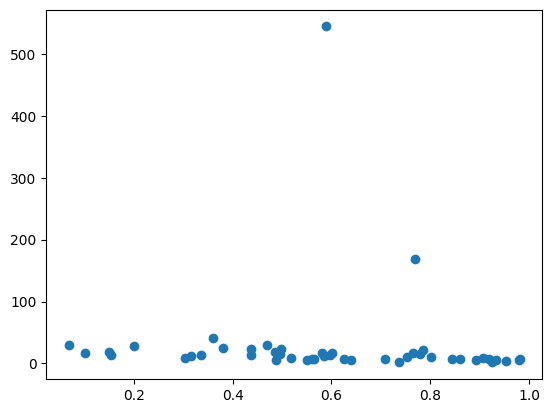

In [17]:
plt.plot(faithfulness, weight_stds, "o")

In [9]:
lre_stats

{'person_occupation': {'relation': 'person_occupation',
  'faithfulness': array([[0.47019868, 0.61151079, 0.39634146, 0.52941176, 0.49681529,
          0.49677419, 0.45454545, 0.51724138, 0.46575342, 0.57777778,
          0.5877193 , 0.37410072, 0.64285714, 0.56074766, 0.37956204,
          0.59016393, 0.57936508, 0.42944785, 0.32989691, 0.44029851]]),
  'causality': array([[0.63576159, 0.61870504, 0.61585366, 0.62184874, 0.56687898,
          0.56774194, 0.62937063, 0.63793103, 0.71917808, 0.56296296,
          0.5877193 , 0.63309353, 0.62087912, 0.47663551, 0.70072993,
          0.48360656, 0.57142857, 0.63190184, 0.57731959, 0.64925373]]),
  '|weight|': array([[[20.3125   , 35.71875  , 30.328125 , 53.09375  , 51.5      ,
           21.078125 , 47.40625  , 28.828125 ],
          [14.84375  , 36.9375   , 31.59375  , 66.1875   , 22.0625   ,
           30.03125  , 26.640625 , 17.421875 ],
          [18.8125   , 11.       , 12.7578125, 17.78125  , 13.4453125,
           22.5      , 38.06